### Training MLP on MNIST 

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
'''
By default the the data is in form of tuples where the first element is image in PIL and 
the second object is its label. By applying the transform operation we are converting it
into tuple of tensor image and label. To convert the images by looping then  the following code may help.
Otherwise pass the transform argument which will be applied to the whole dataset.

What are the benefits of using the dataloader and dataset.mnist direct rather than importing explicitly.
Here the data is already normalized and it is easy to maintain the data using the torch utility rather
than doing it explicitly.
'''



'''
Data Loading Order and Sampler
For iterable-style datasets, data loading order is entirely controlled by the user-defined iterable.
 This allows easier implementations of chunk-reading and dynamic batch size (e.g., by yielding a batched sample at each time).

The rest of this section concerns the case with map-style datasets. torch.utils.data.Sampler classes are 
used to specify the sequence of indices/keys used in data loading. They represent iterable objects over 
the indices to datasets. E.g., in the common case with stochastic gradient decent (SGD), a Sampler could 
randomly permute a list of indices and yield each one at a time, or yield a small number of them for mini-batch SGD.

A sequential or shuffled sampler will be automatically constructed based on the shuffle argument to a DataLoader. 
Alternatively, users may use the sampler argument to specify a custom Sampler object that at each time yields the next index/key to fetch.

A custom Sampler that yields a list of batch indices at a time can be passed as the batch_sampler argument.
 Automatic batching can also be enabled via batch_size and drop_last arguments. See the next section for more details on this.
'''

transform = transforms.ToTensor()
train_data = datasets.MNIST(root = 'data', train = True, download = True,transform=transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True,transform=transform)

In [3]:
# for image,label in train_data:
    # print(type(image))
    # print(transform(image),label)

In [4]:
# for image,label in test_data:
    # print(type(image))
    # print(transform(image),label)

In [5]:
print(train_data[10])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [6]:
'''
Here we dont need to scale teh images between 0 to 1 because they are already normalized 
in the mnist data provided by the torch library.

Moving on now we need to shuffle the data. We have test and train sets. Now we will create 
validation set from training examples.
To do so we will use np.random.permutation.

Here I am exploring the dataloaders from the torch. So what is a dataloader. It is a utility
in torch that helps in batching,shuffling and parallelism of the data.

Samplers: A sampler in pytorch samples form the dataset according to the provided criteria.
Here i will be using a sampler to divide the data into train and validation parts.


In the following outputs we can see that the train loader has length of 657. Our batch size if 64
so 64x657 = 0.7 * 60000 approx. So the train loader divides the train data and the validation data
in multiple batches of size 64.
'''

samples = len(train_data)
index = np.random.permutation(samples)

split = int(np.floor(0.3*samples))
train_idxs  ,valid_idxs = index[split:],index[:split]

train_sampler = SubsetRandomSampler(train_idxs)
valid_sampler = SubsetRandomSampler(valid_idxs)

batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


In [7]:
print(len(train_loader))

657


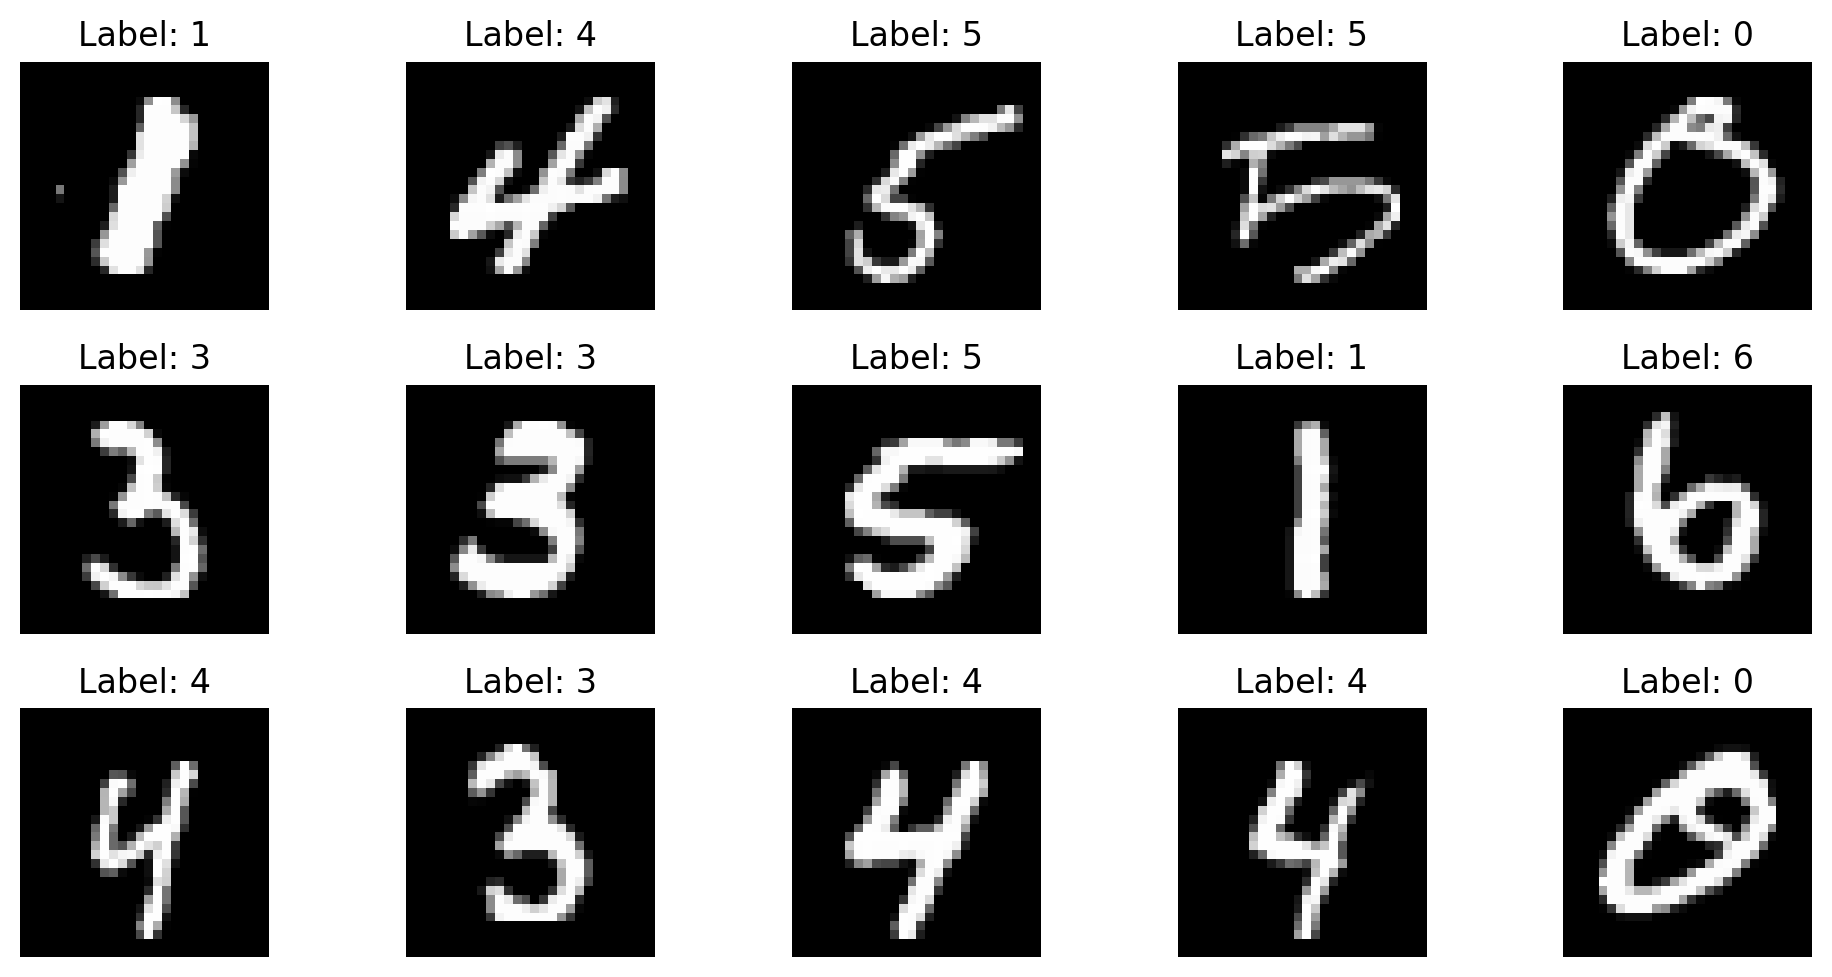

In [8]:
'''
Visualizing the data from the first batch.


How to create an iterator and what are next and iter ??

iter creates an iterator for any object so passing in the index will give the next object for it.

next object retrieves the next item from an iterator

'''

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(3, 5, figsize=(10, 5))
axes = axes.flatten()

for i in range(15): 
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
'''
Defining the architecture of the model.

'''

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_1 = 512
        hidden_2 = 512
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

model = MLP()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 512]         262,656
            Linear-3                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57
----------------------------------------------------------------


In [10]:
'''
Setting up the optimizer and the loss function
'''
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
'''
Now we will train the model.
'''

epochs = 50

for epoch in range(epochs):
    model.train()  
    curr_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = curr_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Validation step
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation during validation
        for images, labels in valid_loader:
            outputs = model(images)
            # print(outputs.shape)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = correct / total
    print(f'Validation Accuracy: {validation_accuracy:.4f}')

# Optionally, you can save the model after training
torch.save(model.state_dict(), 'mlp_mnist.pth')

Epoch [1/50], Loss: 0.0051
Validation Accuracy: 0.9796
Epoch [2/50], Loss: 0.0055
Validation Accuracy: 0.9812
Epoch [3/50], Loss: 0.0035
Validation Accuracy: 0.9791
Epoch [4/50], Loss: 0.0089
Validation Accuracy: 0.9758
Epoch [5/50], Loss: 0.0087
Validation Accuracy: 0.9783
Epoch [6/50], Loss: 0.0050
Validation Accuracy: 0.9808
Epoch [7/50], Loss: 0.0044
Validation Accuracy: 0.9766
Epoch [8/50], Loss: 0.0068
Validation Accuracy: 0.9788
Epoch [9/50], Loss: 0.0097
Validation Accuracy: 0.9823
Epoch [10/50], Loss: 0.0020
Validation Accuracy: 0.9806
Epoch [11/50], Loss: 0.0057
Validation Accuracy: 0.9794
Epoch [12/50], Loss: 0.0106
Validation Accuracy: 0.9783
Epoch [13/50], Loss: 0.0036
Validation Accuracy: 0.9805
Epoch [14/50], Loss: 0.0047
Validation Accuracy: 0.9797
Epoch [15/50], Loss: 0.0036
Validation Accuracy: 0.9798
Epoch [16/50], Loss: 0.0050
Validation Accuracy: 0.9737
Epoch [17/50], Loss: 0.0066
Validation Accuracy: 0.9755
Epoch [18/50], Loss: 0.0044
Validation Accuracy: 0.9790
E

In [11]:
model.load_state_dict(torch.load('mlp_mnist.pth'))

/tmp/ipykernel_7693/3042003745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp_mnist.pth'))


<All keys matched successfully>

In [15]:
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

model.eval()
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        outputs = model(images)
        # print(outputs)
        max_logits, predicted = torch.max(outputs.data, 1)
        # print()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())


test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score: {f1:.4f}')

conf = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
display(pd.DataFrame(conf))


tensor([40.2929, 46.7909, 28.2027, 36.1416, 33.3171, 38.2257, 31.1885, 17.7917,
         5.2651, 31.7364, 54.3665, 62.4231, 23.5518, 34.8912, 39.6386, 33.3933,
        36.3419, 33.2473, 20.1684, 34.2362, 17.6011, 40.9325, 39.6409, 46.3633,
        19.4934, 55.4907, 48.0020, 35.5794, 44.3871, 34.4124, 47.1001, 32.7165,
        44.3312, 28.7219, 32.7740, 38.2924, 35.2322, 36.2562, 22.7563, 31.3868,
        32.3329, 28.4744, 37.2144, 14.3304, 29.4319, 30.3114, 24.9528, 47.7137,
        38.4796, 33.6588, 29.6401, 41.1508, 26.5350, 21.7077, 72.2346, 29.8429,
        56.6419, 33.9017, 30.5636, 26.4871, 78.6028, 30.3356, 11.3343, 15.4207])
tensor([33.4612, 13.8489, 53.5911, 61.9013, 35.9733, 71.9303, 54.6510, 69.1095,
        46.3924, 27.6394, 24.2157, 59.0483, 47.1937, 43.0254, 21.9657, 52.3169,
        20.2203, 39.2086, 61.5415, 47.8221, 26.6915, 45.7116, 35.3974, 58.6149,
        75.0548, 17.1963, 41.4678, 57.7991, 17.9403, 13.3088, 39.7197, 31.2983,
         8.3925, 31.7982, 27.1518, 33.7

0     1     2    3    4    5    6     7    8    9
0  968     1     0    1    1    1    5     0    2    1
1    0  1129     0    2    0    0    2     0    2    0
2    3     1  1013    1    2    0    3     8    1    0
3    0     0     3  999    0    4    0     3    1    0
4    2     0     5    0  961    2    3     1    0    8
5    2     0     0    7    2  871    4     0    4    2
6    1     3     0    1    2    5  944     0    2    0
7    0     6     8    1    1    0    0  1006    1    5
8    0     0     2    7    1    2    1     4  953    4
9    1     3     1    2    6    3    2     5    2  984

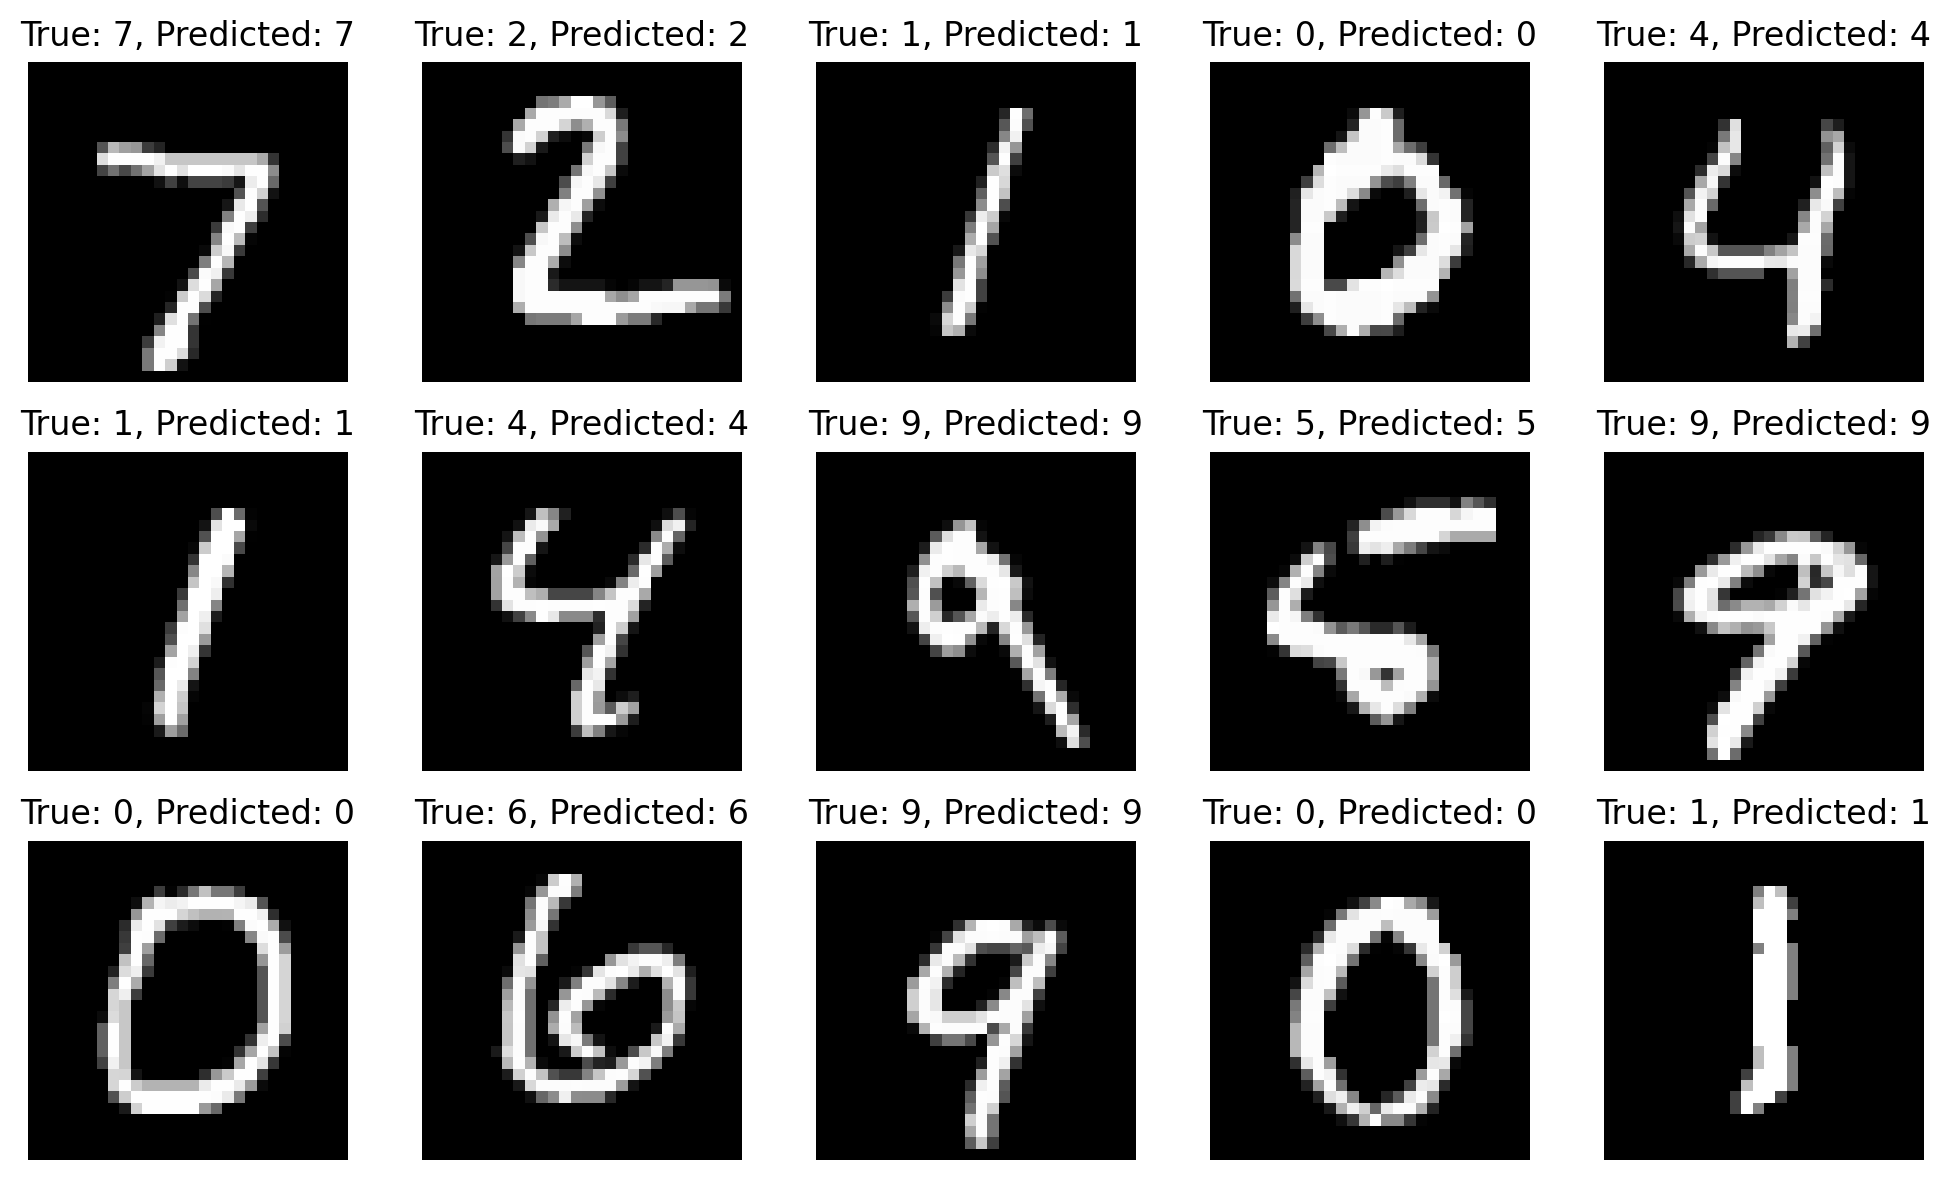

In [13]:
model.eval()

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        fig, axes = plt.subplots(3, 5, figsize=(10, 6))
        axes = axes.flatten()

        for i in range(15):
            axes[i].imshow(images[i].squeeze(), cmap='gray')
            axes[i].set_title(f'True: {labels[i].item()}, Predicted: {predicted[i].item()}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        break

### Training RF on MNIST

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score
import pandas as pd

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for images, labels in train_loader:
    X_train.extend(images.numpy())
    Y_train.extend(labels.numpy())

X_train = np.array(X_train)
Y_train = np.array(Y_train)

for images, labels in valid_loader:
    X_valid.extend(images.numpy())
    Y_valid.extend(labels.numpy())

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

for images, labels in test_loader:
    X_test.extend(images.numpy())
    Y_test.extend(labels.numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)


classifier = RandomForestClassifier(n_estimators=30, random_state=42)
classifier.fit(X_train.reshape(X_train.shape[0], -1), Y_train) 


RandomForestClassifier(n_estimators=30, random_state=42)

In [15]:
Y_valid_pred = classifier.predict(X_valid.reshape(X_valid.shape[0],-1))
accuracy = accuracy_score(Y_valid,Y_valid_pred)
print("Accuracy on Validation set is ",accuracy)

Y_pred = classifier.predict(X_test.reshape(X_test.shape[0], -1))
accuracy = accuracy_score(Y_pred,Y_test)
print("Accuracy on test set is ",accuracy)

f1 = f1_score(Y_test, Y_pred, average='weighted')
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
display(pd.DataFrame(conf_matrix))

Accuracy on Validation set is  0.9608888888888889
Accuracy on test set is  0.9592
F1 Score: 0.9592
Confusion Matrix:


0     1    2    3    4    5    6    7    8    9
0  969     0    1    0    0    3    3    1    3    0
1    0  1122    3    2    1    1    2    1    3    0
2    8     1  991    8    4    2    3   10    4    1
3    0     0   16  960    0    9    1    9   11    4
4    1     0    0    0  950    0    6    3    5   17
5    3     3    0   23    5  841    6    1    7    3
6   10     3    3    1    5    7  925    0    4    0
7    2     5   23    2    4    0    0  976    3   13
8    4     0    8   14    8    7    9    5  912    7
9    8     7    1   12   19    4    1    5    6  946

### Training Logistic Regg on MNIST

In [16]:
'''
Understanding the Parameters
solver='saga':

The saga solver is an optimization algorithm that is suitable for large datasets.
 It can handle both L1 (Lasso) and L2 (Ridge) regularization.
It is particularly efficient for logistic regression with a large number of 
samples or features.

multi_class='multinomial':

This parameter indicates that the logistic regression model should use a multinomial 
loss function for multi-class classification problems.
In the case of MNIST, which has 10 classes (digits 0-9), this setting allows the 
model to handle all classes simultaneously rather than treating them as binary problems (one-vs-rest).
'''


import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for images, labels in train_loader:
    X_train.extend(images.numpy())
    Y_train.extend(labels.numpy())

X_train = np.array(X_train)
Y_train = np.array(Y_train)

for images, labels in valid_loader:
    X_valid.extend(images.numpy())
    Y_valid.extend(labels.numpy())

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

for images, labels in test_loader:
    X_test.extend(images.numpy())
    Y_test.extend(labels.numpy())

X_test = np.array(X_test)
Y_test = np.array(Y_test)


classifier = LogisticRegression(solver='saga', multi_class='multinomial')
classifier.fit(X_train.reshape(X_train.shape[0], -1), Y_train) 

/home/haarit/myenv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/haarit/myenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='saga')

In [17]:
Y_valid_pred = classifier.predict(X_valid.reshape(X_valid.shape[0],-1))
accuracy = accuracy_score(Y_valid,Y_valid_pred)
print("Accuracy on Validation set is ",accuracy)

Y_pred = classifier.predict(X_test.reshape(X_test.shape[0], -1))
accuracy = accuracy_score(Y_pred,Y_test)
print("Accuracy on test set is ",accuracy)

f1 = f1_score(Y_test, Y_pred, average='weighted')
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
display(pd.DataFrame(conf_matrix))

Accuracy on Validation set is  0.9197222222222222
Accuracy on test set is  0.9246
F1 Score: 0.9245
Confusion Matrix:


0     1    2    3    4    5    6    7    8    9
0  951     0    3    2    0   13    5    5    1    0
1    0  1114    3    2    0    3    3    1    9    0
2    6     6  931   14    8    3   13    8   38    5
3    3     0   17  917    0   26    4   12   23    8
4    1     2    7    3  912    0   11    6    8   32
5    9     2    4   36    9  775   15    7   29    6
6   10     3    9    1    8   14  909    3    1    0
7    1     8   24    5    4    2    0  951    2   31
8    6    12    7   19   10   26   12    8  862   12
9    8     7    2   10   22    7    0   22    7  924

In [ ]:
dd

### Comparing t-SNE for trained , untrained and trianed model with Fashion MNIST 

In [4]:
'''
TSNE : t distributed stochastic neighbour embedding
t-distributed : the algorithm uses a distribution called t-distribution
                it is like normal distribution but less value at mean and the
                flaps are bit higher. This ensures the mapping does result into clusters 
                not centered at one point.
            
stochastic : It is due to the random nature of the algorithm. The embedding process involves random initialization
            and random sampling. So different runs give different results.

neighbour : Refers to the distance property that is retained during the processing of data. It tries to locate the
            neighbours in lowers dimension based on their relative distances in higher dimension.

embedding : transforming the data from higher dimensional space to lower dimensional space. In general embedding means to
            encode data in some format.

'''

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

class MLP_tsne(nn.Module):
    def __init__(self):
        super(MLP_tsne, self).__init__()
        hidden_1 = 30
        hidden_2 = 20
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)
        return x

model = MLP_tsne()
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [6]:
'''
Setting up the optimizer and the loss function
'''
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

'''
Now we will train the model.
'''

epochs = 50

for epoch in range(epochs):
    model.train()  
    curr_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = curr_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Validation step
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation during validation
        for images, labels in valid_loader:
            outputs = model(images)
            # print(outputs.shape)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = correct / total
    print(f'Validation Accuracy: {validation_accuracy:.4f}')

# Optionally, you can save the model after training
torch.save(model.state_dict(), 'mlp_mnist_tsne.pth')

Epoch [1/50], Loss: 0.6024
Validation Accuracy: 0.9137
Epoch [2/50], Loss: 0.2726
Validation Accuracy: 0.9282
Epoch [3/50], Loss: 0.2219
Validation Accuracy: 0.9350
Epoch [4/50], Loss: 0.1920
Validation Accuracy: 0.9448
Epoch [5/50], Loss: 0.1685
Validation Accuracy: 0.9476
Epoch [6/50], Loss: 0.1497
Validation Accuracy: 0.9496
Epoch [7/50], Loss: 0.1347
Validation Accuracy: 0.9525
Epoch [8/50], Loss: 0.1230
Validation Accuracy: 0.9547
Epoch [9/50], Loss: 0.1131
Validation Accuracy: 0.9549
Epoch [10/50], Loss: 0.1037
Validation Accuracy: 0.9557
Epoch [11/50], Loss: 0.0946
Validation Accuracy: 0.9557
Epoch [12/50], Loss: 0.0894
Validation Accuracy: 0.9558
Epoch [13/50], Loss: 0.0817
Validation Accuracy: 0.9571
Epoch [14/50], Loss: 0.0763
Validation Accuracy: 0.9584
Epoch [15/50], Loss: 0.0712
Validation Accuracy: 0.9602
Epoch [16/50], Loss: 0.0667
Validation Accuracy: 0.9608
Epoch [17/50], Loss: 0.0626
Validation Accuracy: 0.9588
Epoch [18/50], Loss: 0.0578
Validation Accuracy: 0.9600
E

In [40]:
model_ut = MLP_tsne()

model.eval()
model_ut.eval()

outputs_layer2_ut = []

outputs_layer2 = []
ylabels = []

with torch.no_grad():
    for images,labels in train_loader:
        for i,(image,label) in enumerate(zip(images,labels)):
                
            x = image.view(-1, 28*28)
            x = F.relu(model.fc1(x))
            x = model.fc2(x)

            outputs_layer2.append(x.squeeze().numpy())
            ylabels.append(label.numpy())

            x = image.view(-1, 28*28)
            x = F.relu(model_ut.fc1(x))
            x = model_ut.fc2(x)

            outputs_layer2_ut.append(x.squeeze().numpy())



samples = 6000

outputs_layer2 = np.array(outputs_layer2[:samples])
ylabels  = np.array(ylabels[:samples])

outputs_layer2_ut = np.array(outputs_layer2_ut[:samples])

print(outputs_layer2.shape)

(6000, 20)


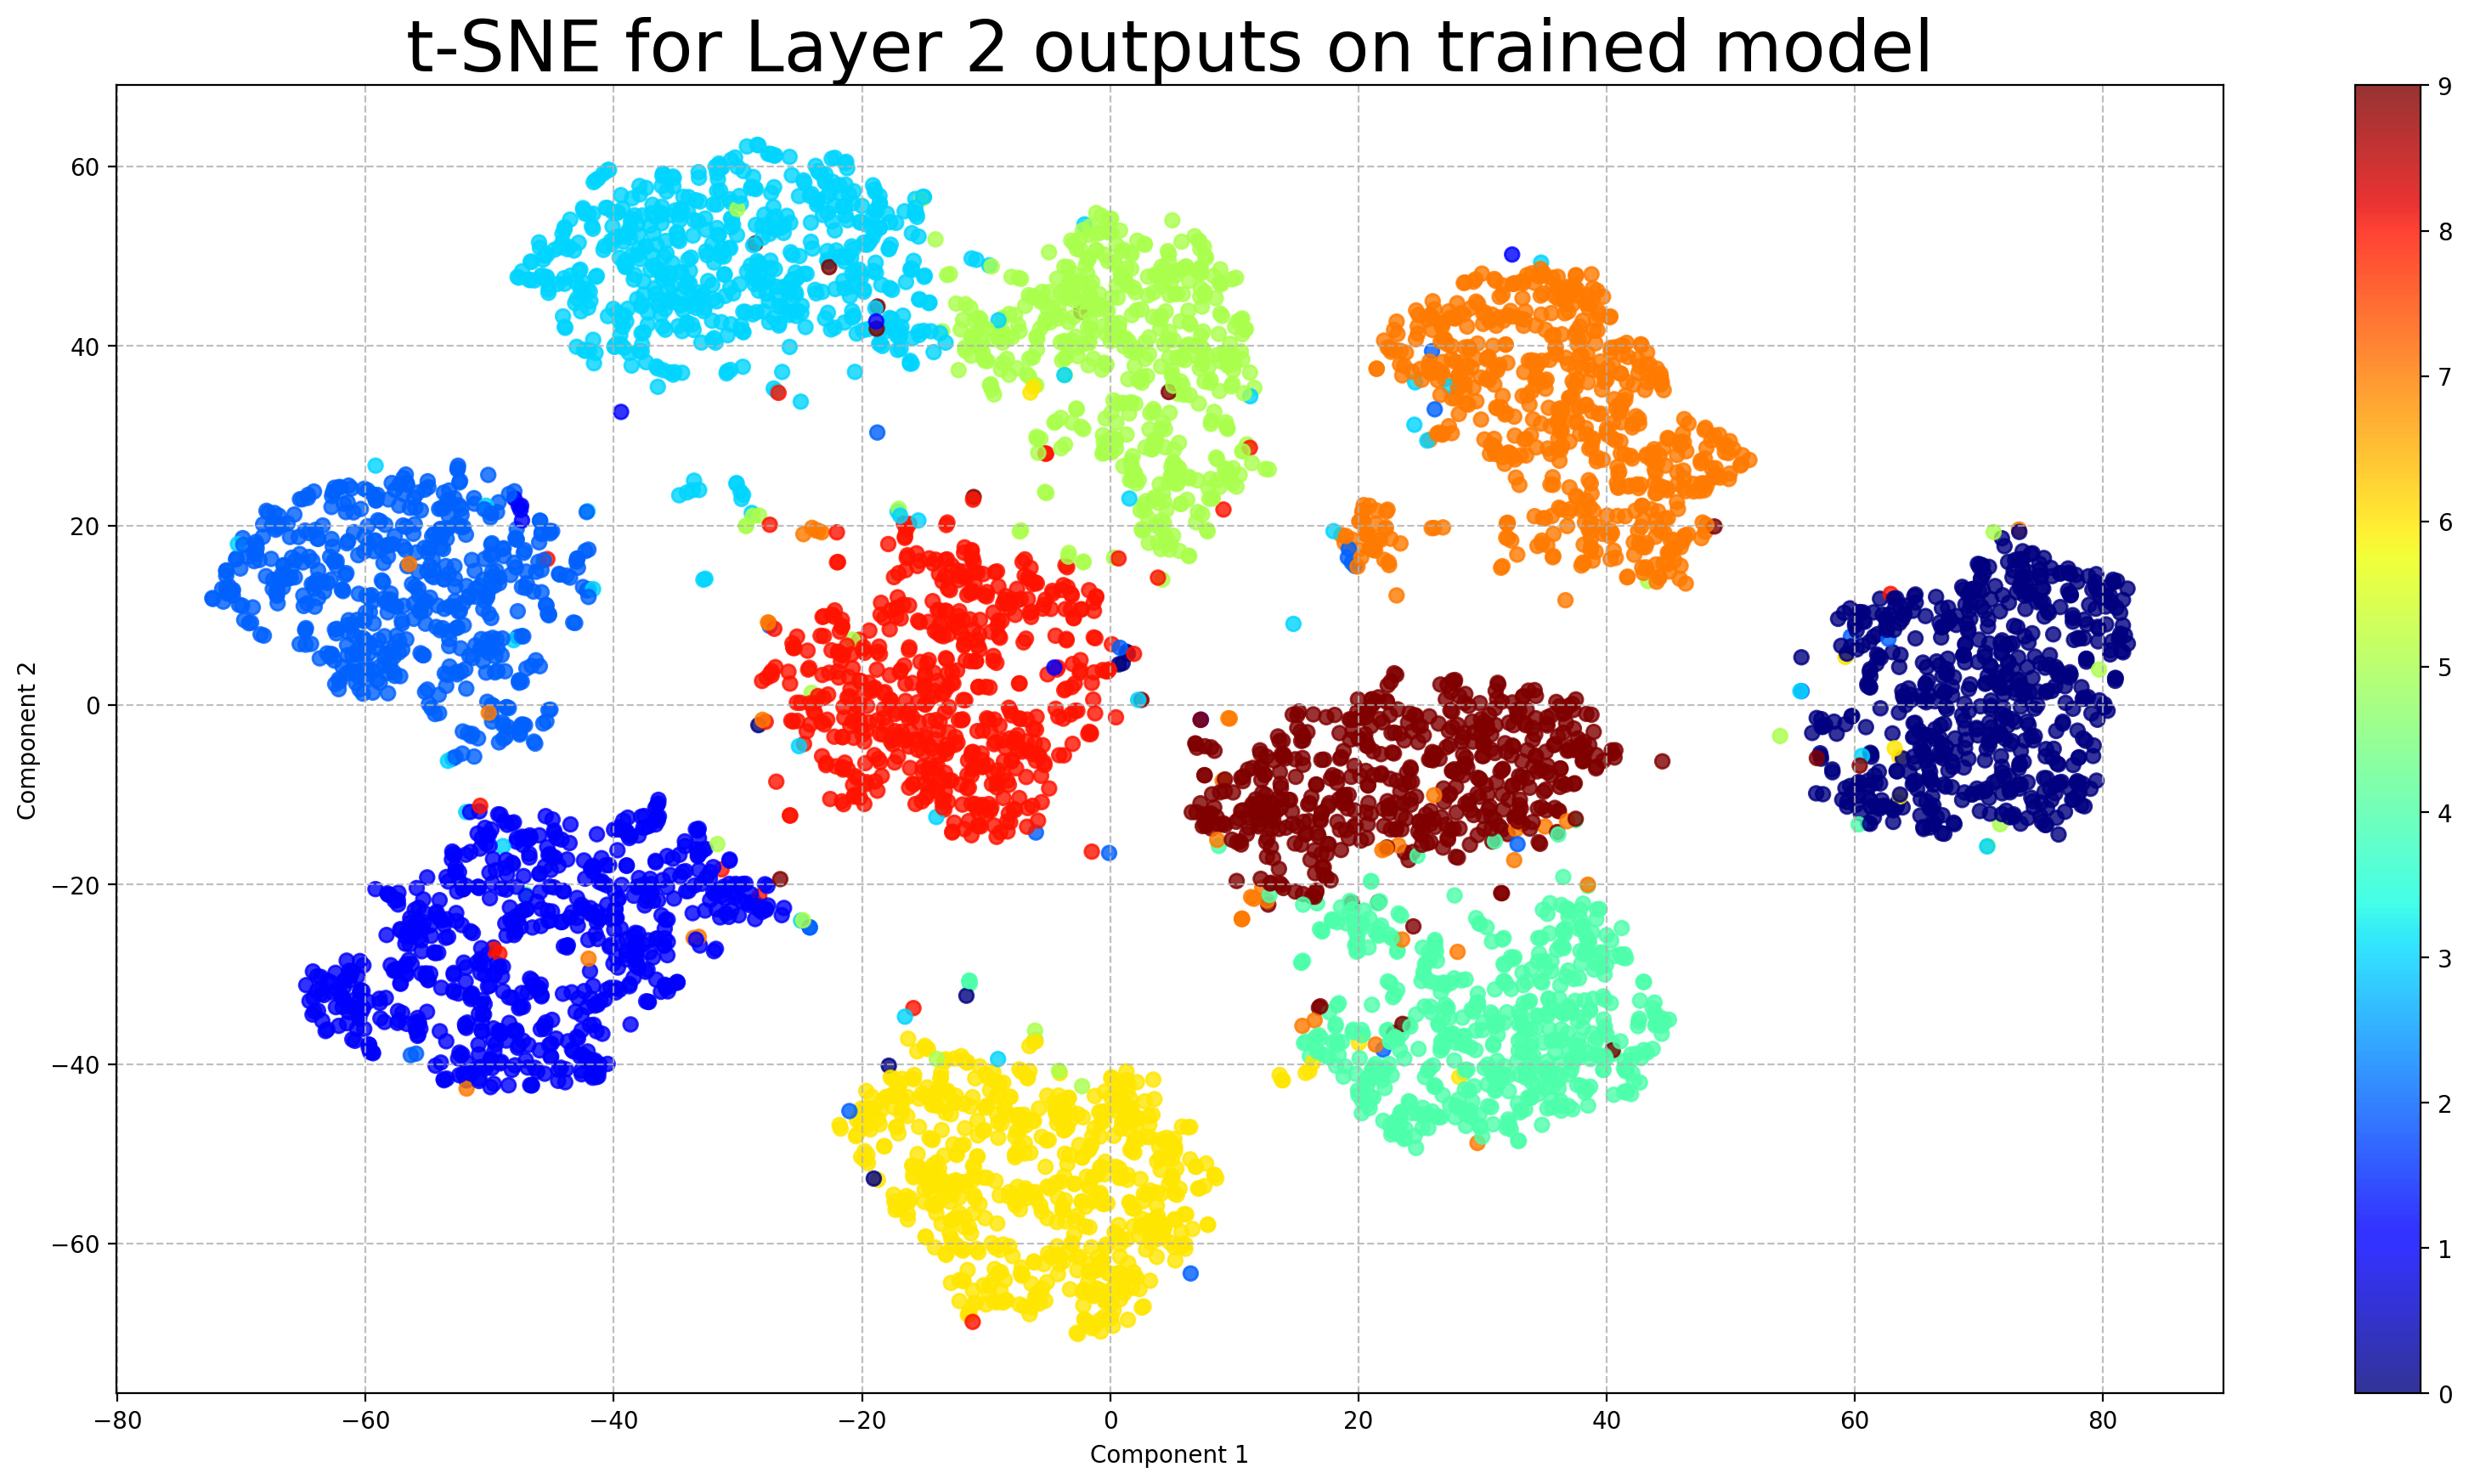

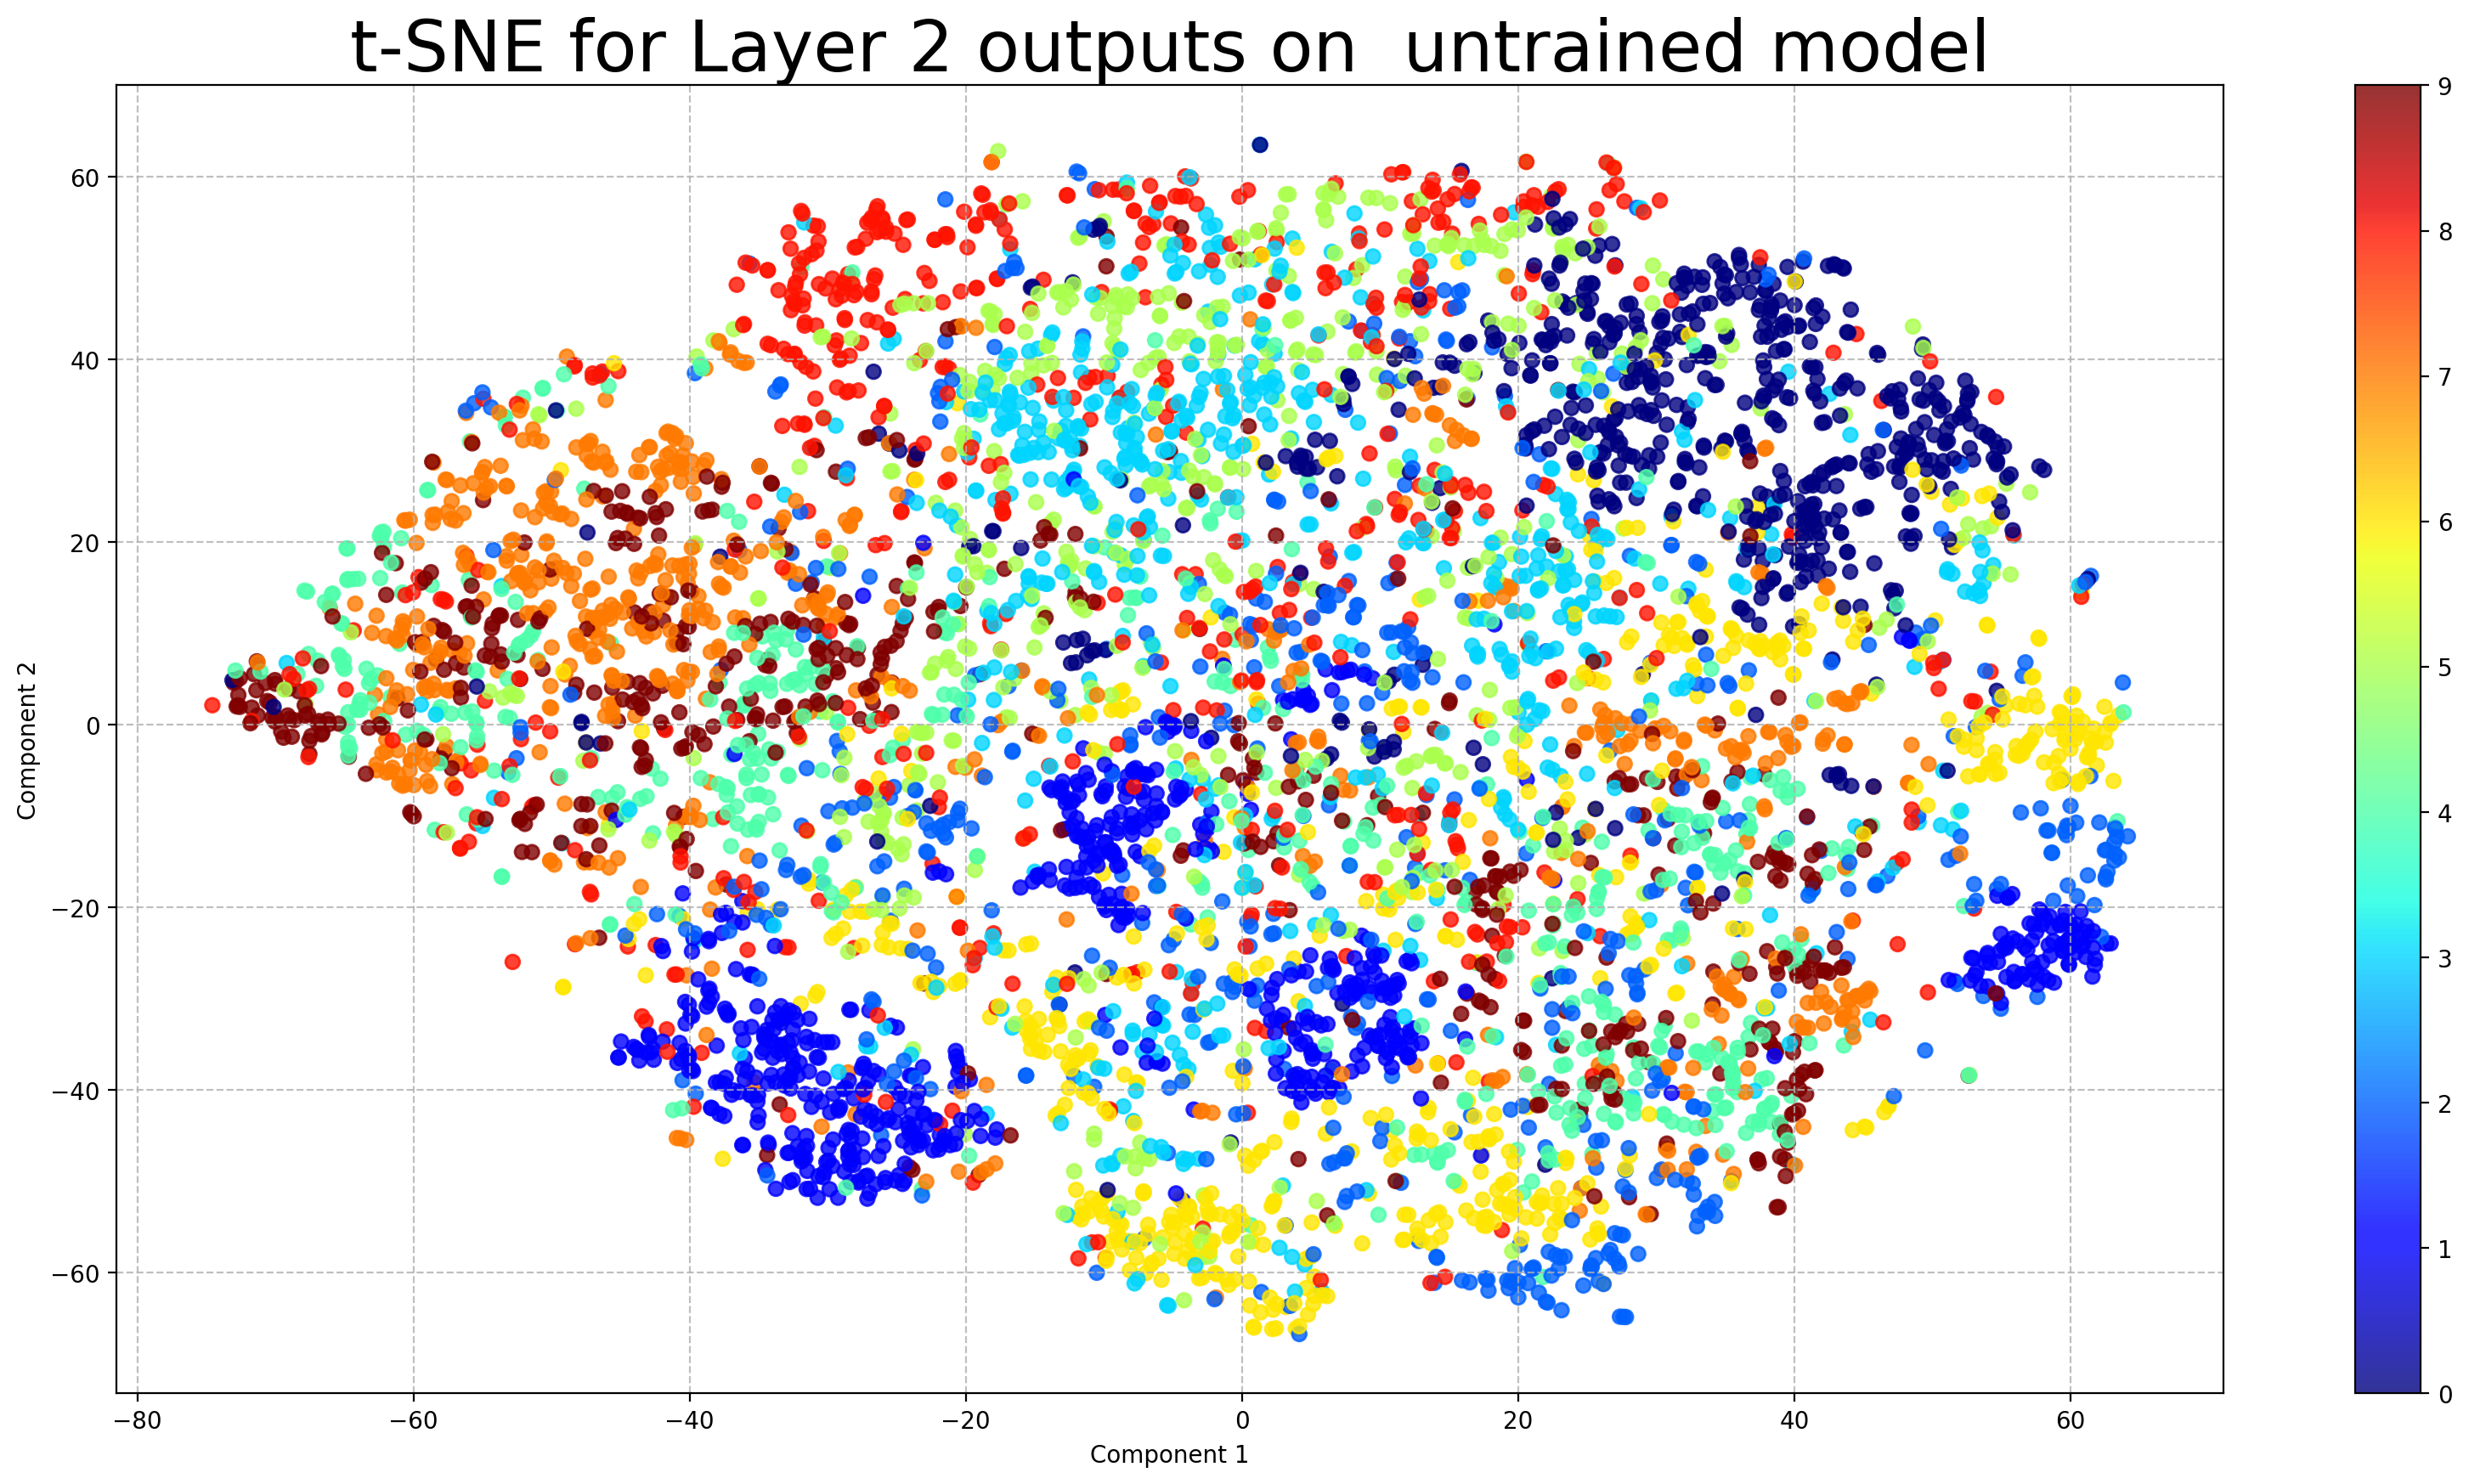

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
transformed_components = tsne.fit_transform(outputs_layer2)


plt.figure(figsize=(20,10))
plt.grid(linestyle='--', alpha=0.8)
plt.scatter(transformed_components[:, 0], transformed_components[:, 1], c=ylabels.astype(int), cmap='jet',alpha = 0.8)
plt.colorbar()
plt.title('t-SNE for Layer 2 outputs on trained model',size = 30)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


tsne = TSNE(n_components=2, random_state=42)
transformed_components = tsne.fit_transform(outputs_layer2_ut)

plt.figure(figsize=(20,10))
plt.grid(linestyle='--', alpha=0.8)
plt.scatter(transformed_components[:, 0], transformed_components[:, 1], c=ylabels.astype(int), cmap='jet',alpha = 0.8)
plt.colorbar()
plt.title('t-SNE for Layer 2 outputs on  untrained model',size = 30)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [55]:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root = 'data', train = True, download = True,transform=transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True,transform=transform)


samples = len(train_data)
index = np.random.permutation(samples)

split = int(np.floor(0.3*samples))
train_idxs  ,valid_idxs = index[split:],index[:split]

train_sampler = SubsetRandomSampler(train_idxs)

batch_size = 64
num_workers = 0

train_loader_fashion = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)


In [68]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

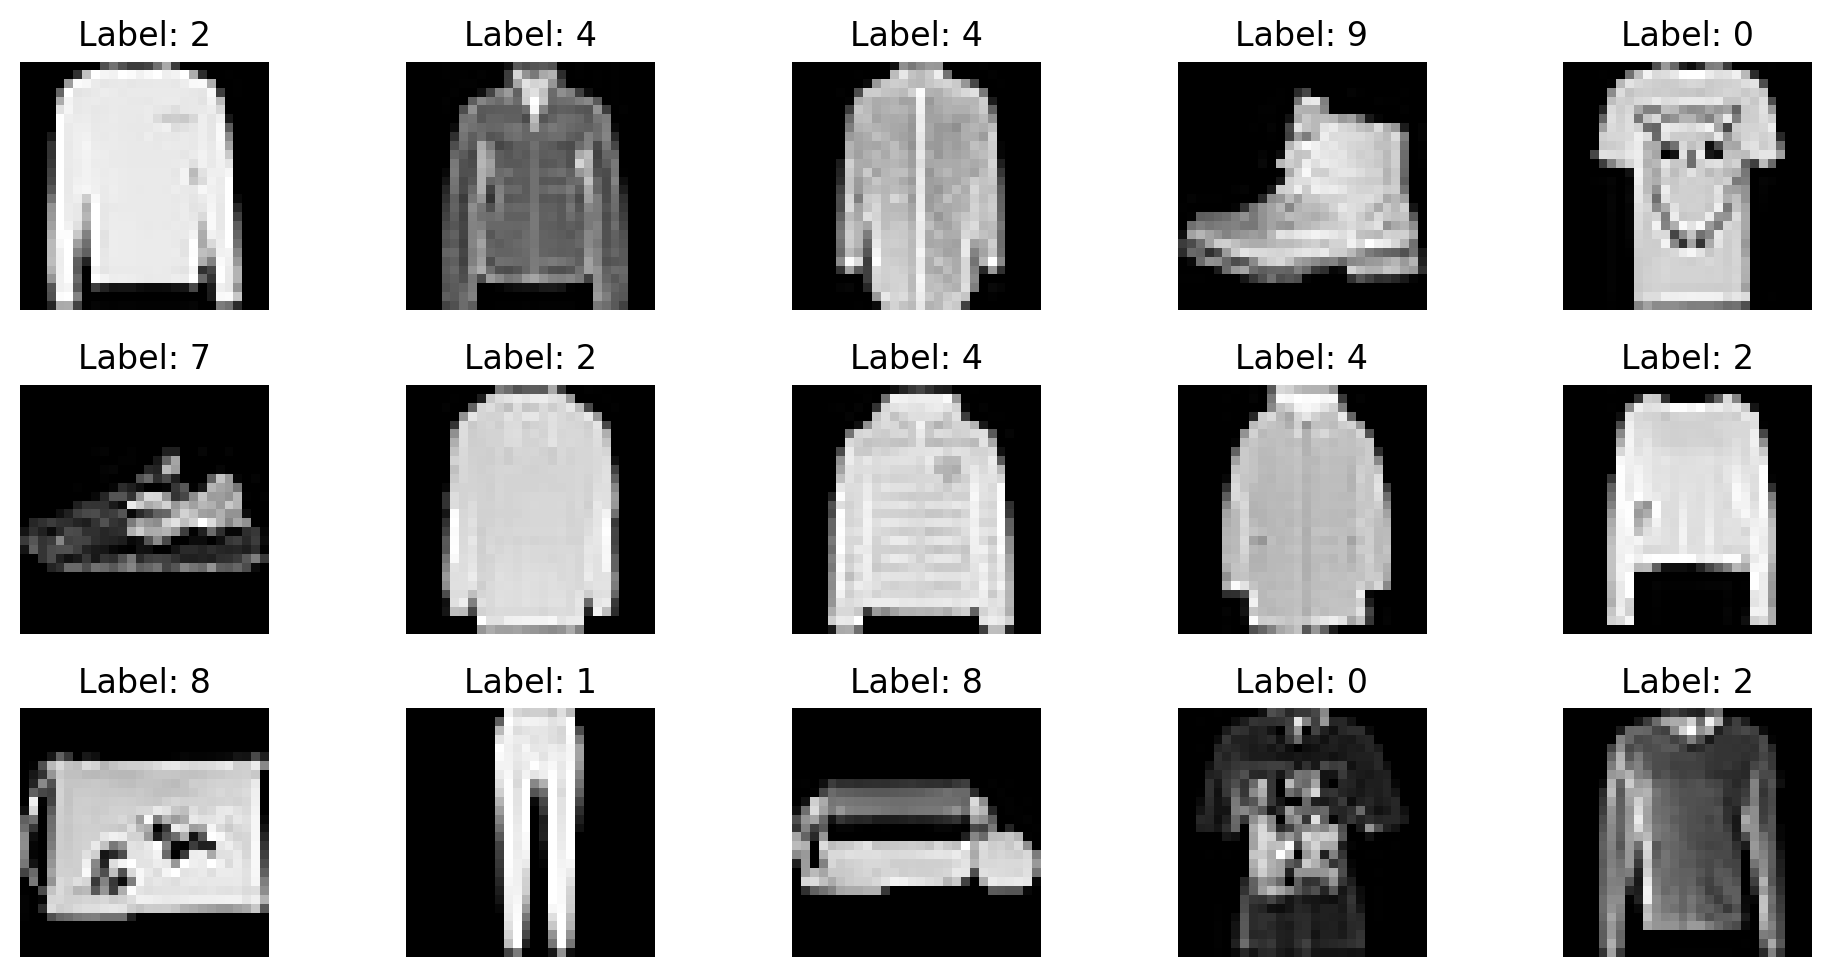

In [61]:
images, labels = next(iter(train_loader_fashion))

print(images.shape)
print(labels.shape)
print(images,labels)

fig, axes = plt.subplots(3, 5, figsize=(10, 5))
axes = axes.flatten()

for i in range(15): 
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [65]:
# images, labels = next(iter(train_loader))

# for i in range(len(images)):
#     print(images[i].shape)
#     print(labels[i])

model.eval()

outputs_layer2 = []
ylabels = []

with torch.no_grad():
    for images,labels in train_loader_fashion:
        for i,(image,label) in enumerate(zip(images,labels)):
                
            x = image.view(-1, 28*28)
            x = F.relu(model.fc1(x))
            x = model.fc2(x)

            outputs_layer2.append(x.squeeze().numpy())
            ylabels.append(label.numpy())
    
samples = 6000

outputs_layer2 = np.array(outputs_layer2[:samples])
ylabels  = np.array(ylabels[:samples])

print(outputs_layer2.shape)

(6000, 20)


In [66]:
ylabels

array([4, 0, 7, ..., 6, 7, 3])

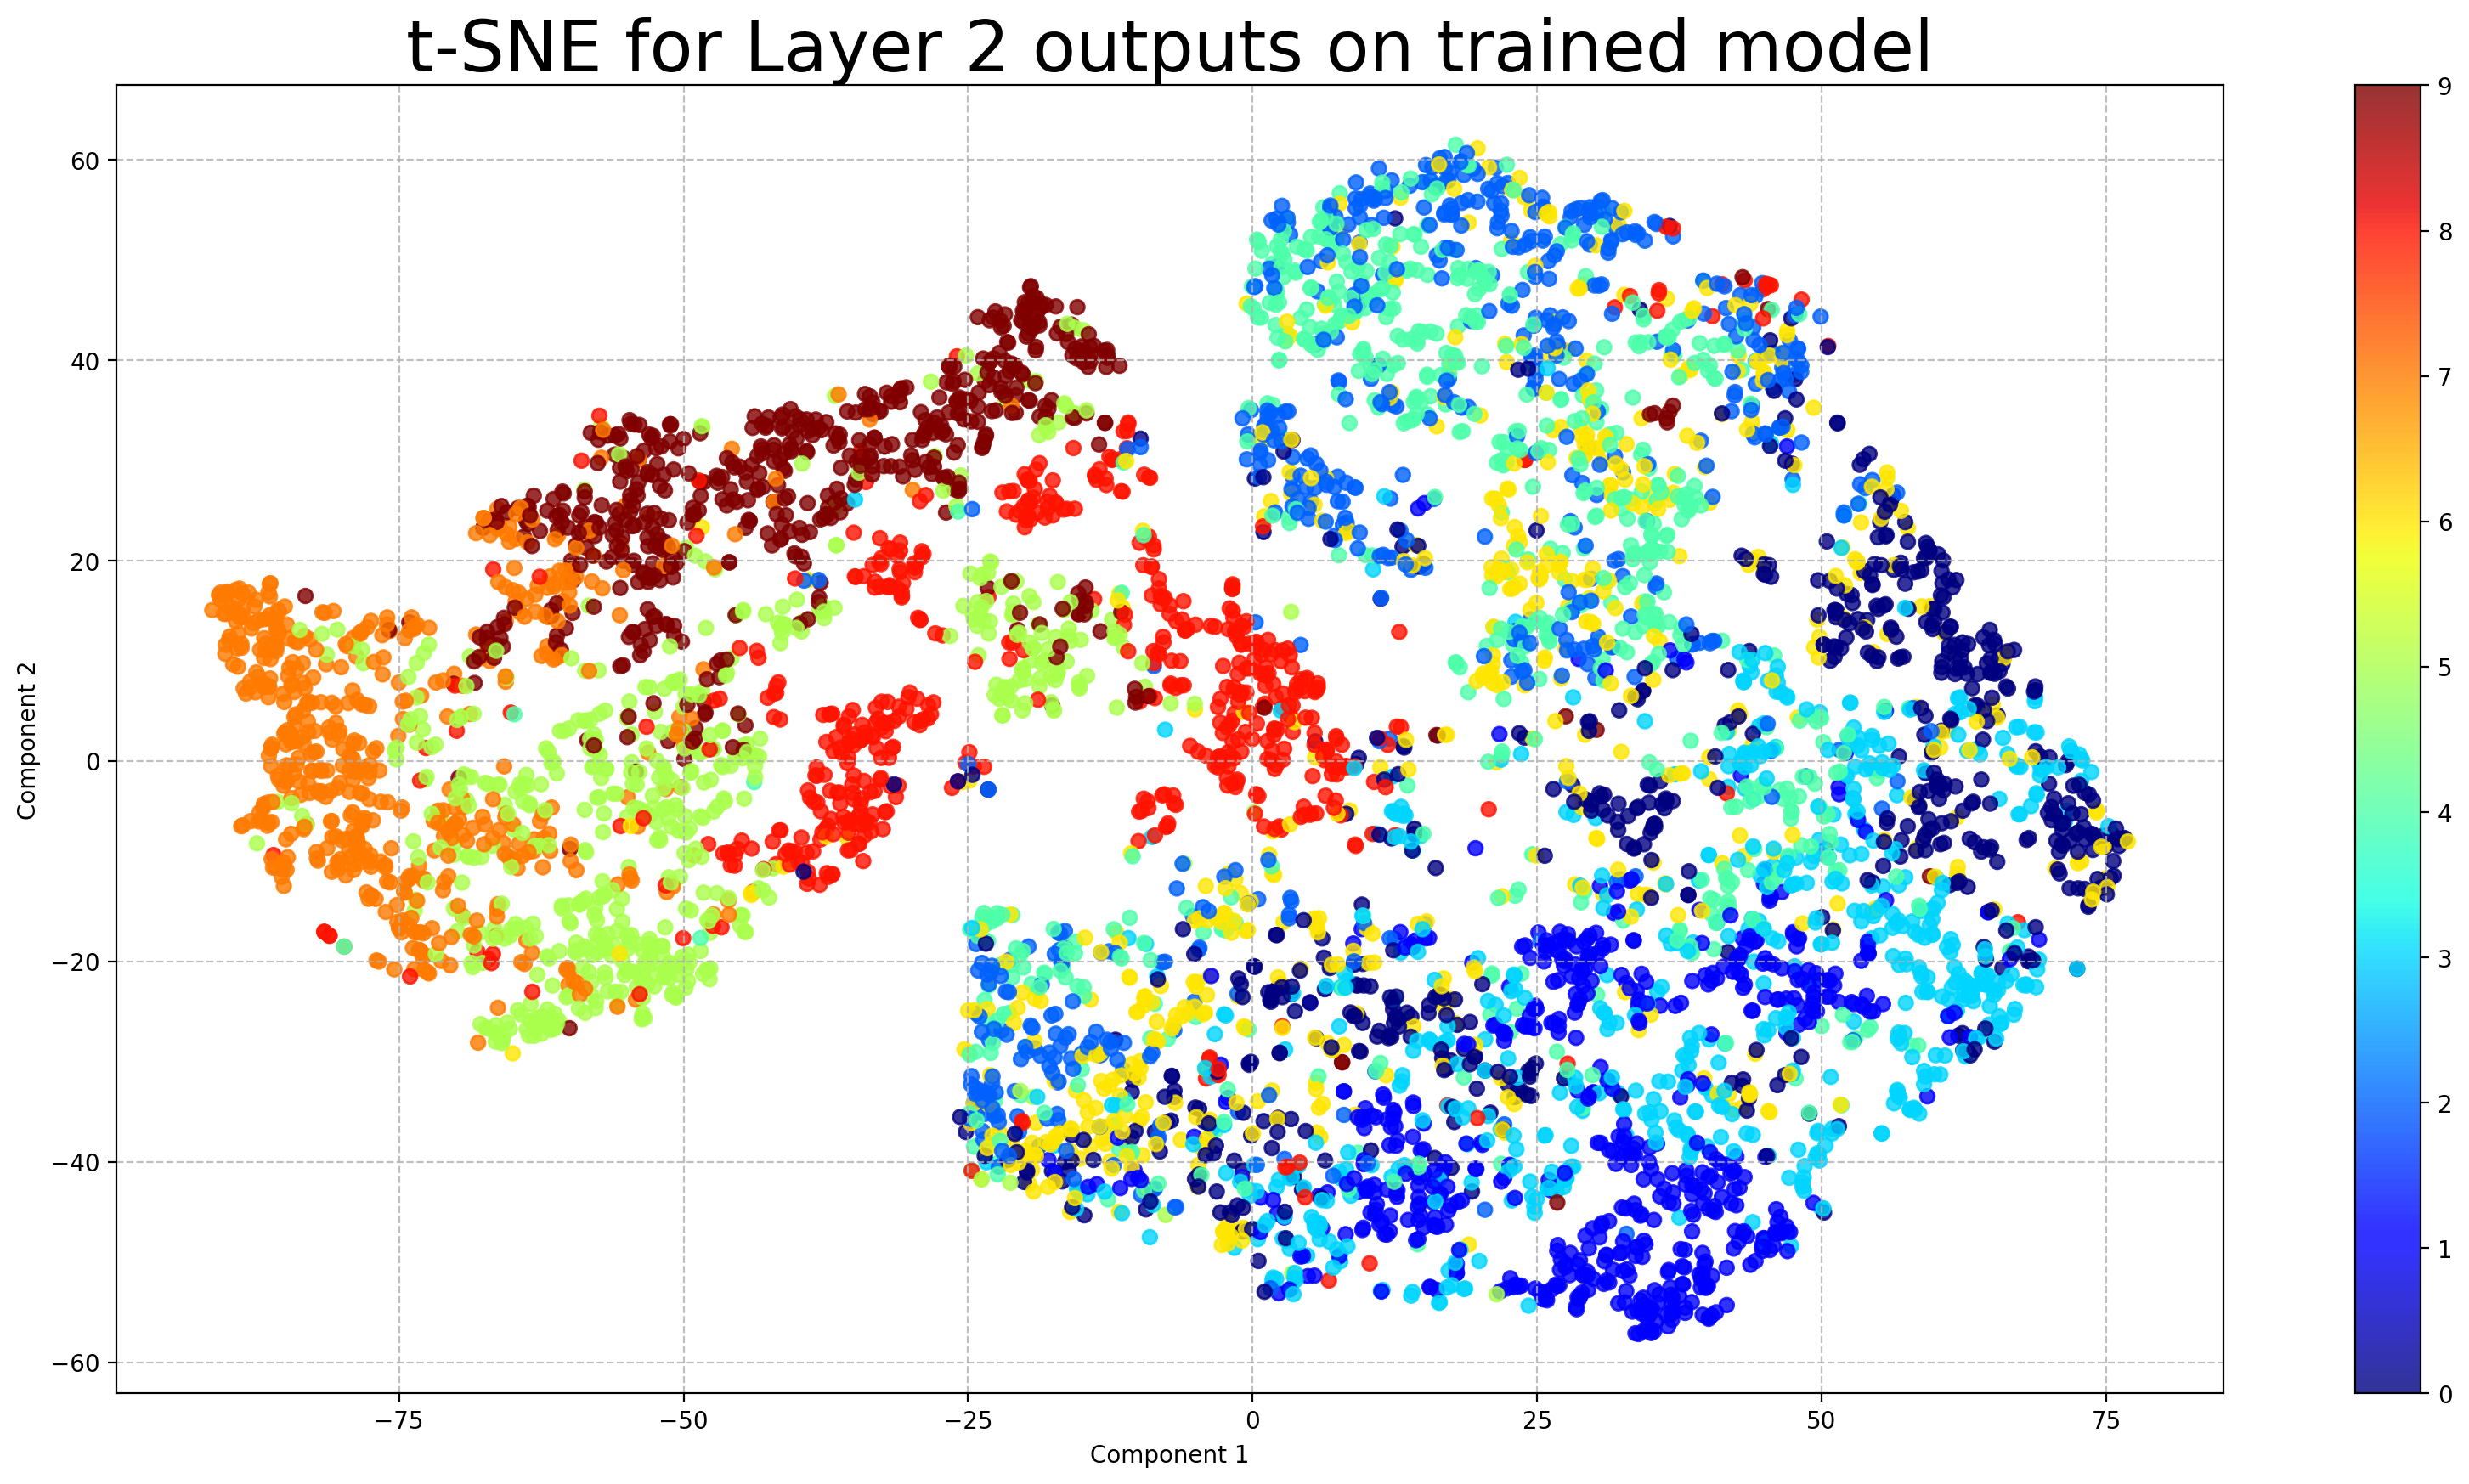

In [67]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
transformed_components = tsne.fit_transform(outputs_layer2)


plt.figure(figsize=(20,10))
plt.grid(linestyle='--', alpha=0.8)
plt.scatter(transformed_components[:, 0], transformed_components[:, 1], c=ylabels.astype(int), cmap='jet',alpha = 0.8)
plt.colorbar()
plt.title('t-SNE for Layer 2 outputs on trained model (Fashion MNIST)',size = 30)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()